In [102]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from matplotlib import pyplot as plt
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.regularizers import l2

# Data Analysis

In [103]:
def analyzeStockData(companyName: str, df: pd.DataFrame):
    # Print the company name in uppercase with stars
    print("************************************* ")
    print(companyName.upper())
    print("************************************* ")

    # Print the DataFrame information
    print("\n===>>> INFO")
    print(df.columns)

    # Print the descriptive statistics of the DataFrame
    # print("\n===>>> DESCRIBE")
    # print(df.describe().to_string())

    # Print the first few rows of the DataFrame
    print("\n===>>> HEAD")
    print(df.head())

def modelSummary(model):
    print("\n\n===>>> MODEL SUMMARY\n")
    print(model.summary())
    print("\n\n")

# Graphs Utils



In [104]:
def plot_high_low_close_data(df: pd.DataFrame):
    """
    Plot the high, low, and close prices along with volume data.

    Parameters:
        df (pd.DataFrame): DataFrame containing high, low, close, and volume data.
    """
    # Create the subplots
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 5))

    # Plot the high, low, and close prices on the first subplot
    ax1.plot(df['High'], label='High')
    ax1.plot(df['Low'], label='Low')
    ax1.plot(df['Close'], label='Close')

    # Set the title and labels for the first subplot
    ax1.set_title('High, Low, and Close Prices')
    ax1.set_ylabel('Price')
    ax1.legend(loc='upper left')

    # Plot the volume on the second subplot
    ax2.bar(df.index, df['Volume'])

    # Set the title and labels for the second subplot
    ax2.set_title('Volume')
    ax2.set_ylabel('Volume')
    ax2.set_xlabel('Date')

    # Rotate the x-axis labels on the second subplot
    plt.xticks(rotation=35)

    # Show the plot
    plt.tight_layout()
    plt.show()


def plot_stock_averages(df: pd.DataFrame):
    """
    Plot stock close price along with moving averages.

    Parameters:
        df (pd.DataFrame): DataFrame containing stock data.
    """
    # Compute the moving averages
    df['1W_MA'] = df['Close'].rolling(window=7).mean()  # 1-week moving average
    df['1M_MA'] = df['Close'].rolling(window=30).mean() # 1-month moving average (assuming 30 days as a month)
    df['3M_MA'] = df['Close'].rolling(window=90).mean() # 3-month moving average (assuming 60 days as a month)


    # Create the plot
    plt.figure(figsize=(10, 5))

    # Plot the close prices
    plt.plot(df['Close'], label='Close Price', linewidth=1)

    # Plot the moving averages
    plt.plot(df['1W_MA'], label='Weekly Moving Average', linewidth=1.5)
    plt.plot(df['1M_MA'], label='Monthly Moving Average', linewidth=1.5)
    plt.plot(df['3M_MA'], label='Quarterly Moving Average', linewidth=1.5)

    # Set the title and labels
    plt.title('Stock Close Price with Moving Averages')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend(loc='upper left')

    # Rotate the x-axis labels for better readability
    plt.xticks(rotation=35)

    # Show the plot
    plt.tight_layout()
    plt.show()

def plot_stock_data(df: pd.DataFrame):
    """
    Plot high, low, close prices along with volume and stock close price with moving averages.

    Parameters:
        df (pd.DataFrame): DataFrame containing stock data.
    """
    # Create the subplots
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))

    # Plot high, low, close data along with volume
    axes[0].plot(df['High'], label='High')
    axes[0].plot(df['Low'], label='Low')
    axes[0].plot(df['Close'], label='Close')
    axes[0].set_title('High, Low, and Close Prices')
    axes[0].set_ylabel('Price')
    axes[0].legend(loc='upper left')

    axes[1].bar(df.index, df['Volume'])
    axes[1].set_title('Volume')
    axes[1].set_ylabel('Volume')
    axes[1].set_xlabel('Date')
    axes[1].tick_params(axis='x', rotation=35)
    # Compute the moving averages
    df['1W_MA'] = df['Close'].rolling(window=7).mean()  # 1-week moving average
    df['1M_MA'] = df['Close'].rolling(window=30).mean() # 1-month moving average (assuming 30 days as a month)
    df['3M_MA'] = df['Close'].rolling(window=90).mean() # 3-month moving average (assuming 60 days as a month)

    # Plot stock close price with moving averages
    axes[2].plot(df['Close'], label='Close Price', linewidth=1)
    axes[2].plot(df['1W_MA'], label='Weekly Moving Average', linewidth=1.5)
    axes[2].plot(df['1M_MA'], label='Monthly Moving Average', linewidth=1.5)
    axes[2].plot(df['3M_MA'], label='Quarterly Moving Average', linewidth=1.5)
    axes[2].set_ylabel('Price')
    axes[2].legend(loc='upper left')

    # Set the title and labels for the combined plot
    axes[2].set_title('Stock Close Price with Moving Averages')
    axes[2].set_xlabel('Date')

    # Show the plot
    plt.tight_layout()
    plt.show()

def visualize_predictions(df: pd.DataFrame, predictions: pd.Series, train_size: int):
    """
    Visualize stock price predictions.

    Parameters:
        df (pd.DataFrame): DataFrame containing stock data.
        predictions (pd.Series): Predicted stock prices.
        train_size (int): Size of the training data.
    """
    # Split the DataFrame into training and testing sets
    train = df[:train_size]
    test = df[train_size:].copy()  # Avoid SettingWithCopyWarning

    # Add predictions to the test set
    test['Predictions'] = predictions

    # Create the plot
    plt.figure(figsize=(12, 5))
    plt.plot(train['Close'], label='Training Data')
    plt.plot(test['Close'], label='Actual Stock Price')
    plt.plot(test['Predictions'], label='Predicted Stock Price')

    # Set the title and labels
    plt.title('Stock Price Prediction')
    plt.xlabel('Date')
    plt.ylabel('Stock Price')
    plt.legend()

    # Show the plot
    plt.tight_layout()
    plt.show()


# Data Processing Utils

In [105]:
def create_sequences(data, seq_length):
    """
    Create sequences of data for LSTM.

    Parameters:
        data (np.ndarray): The input data.
        seq_length (int): Length of each sequence.

    Returns:
        np.ndarray, np.ndarray: Input sequences and corresponding target values.
    """
    x = []
    y = []
    for i in range(seq_length, len(data)):
        x.append(data[i - seq_length:i])
        y.append(data[i])
    return np.array(x), np.array(y)

def prepare_lstm_data(scaled_data, seq_length, train_split=0.8):
    """
    Prepare data for LSTM training.

    Parameters:
        scaled_data (np.ndarray): Scaled input data.
        seq_length (int): Length of each sequence.
        train_split (float): Percentage of data to use for training.

    Returns:
        np.ndarray, np.ndarray, np.ndarray, np.ndarray, int: Training and testing data along with the size of the training data.
    """
    # Split into training and testing datasets
    train_size = int(len(scaled_data) * train_split)
    train_data = scaled_data[:train_size]
    test_data = scaled_data[train_size - seq_length:]

    x_train, y_train = create_sequences(train_data, seq_length)
    x_test, y_test = create_sequences(test_data, seq_length)

    # Reshape for LSTM layers (samples, time steps, features)
    x_train = x_train.reshape((x_train.shape[0], x_train.shape[1], 1))
    x_test = x_test.reshape((x_test.shape[0], x_test.shape[1], 1))

    return x_train, y_train, x_test, y_test, train_size


# Build Models

In [106]:
def build_lstm_model(input_shape):
    """
    Build LSTM model with increased units and additional dense layers.

    Parameters:
        input_shape (tuple): Shape of input data.

    Returns:
        keras.Sequential: Compiled LSTM model.
    """
    model = Sequential()
    model.add(LSTM(units=128, return_sequences=True, input_shape=input_shape))
    model.add(Dropout(0.2))
    model.add(LSTM(units=64, return_sequences=False))
    model.add(Dropout(0.2))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mse'])
    return model

def build_lstm_model_2(input_shape):
    """
    Build LSTM model with increased units, adjusted dropout rate, and different activation functions.

    Parameters:
        input_shape (tuple): Shape of input data.

    Returns:
        keras.Sequential: Compiled LSTM model.
    """
    model = Sequential()
    model.add(LSTM(units=64, return_sequences=True, input_shape=input_shape))  # Increased units
    model.add(Dropout(0.3))  # Adjusted dropout rate
    model.add(LSTM(units=32, return_sequences=False))  # Increased units
    model.add(Dropout(0.3))  # Adjusted dropout rate
    model.add(Dense(16, activation='relu'))  # Experiment with different activation function
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

def build_lstm_model_3(input_shape):
    """
    Build LSTM model with increased units, adjusted dropout rate, and different activation functions.

    Parameters:
        input_shape (tuple): Shape of input data.

    Returns:
        keras.Sequential: Compiled LSTM model.
    """
    model = Sequential()
    model.add(LSTM(units=64, return_sequences=False, input_shape=input_shape))  # Increased units
    model.add(Dropout(0.3))  # Adjusted dropout rate
    model.add(Dense(32, activation='relu'))  # Experiment with different activation function
    model.add(Dropout(0.3))  # Adjusted dropout rate
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model


## Metrics

In [107]:
def calculate_mape(y_true, y_pred):
    """
    Calculate Mean Absolute Percentage Error (MAPE) between true and predicted values.

    Parameters:
        y_true (numpy.ndarray): Array of true values.
        y_pred (numpy.ndarray): Array of predicted values.

    Returns:
        float: Mean Absolute Percentage Error (MAPE) in percentage.
    """
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def compute_regression_accuracy(y_true, y_pred, threshold):
    """
    Compute regression accuracy based on a threshold.

    Parameters:
        y_true (numpy.ndarray): Array of true values.
        y_pred (numpy.ndarray): Array of predicted values.
        threshold (float): Threshold value for considering predictions as correct.

    Returns:
        float: Accuracy percentage.
    """
    correct_predictions = np.abs(y_true - y_pred) <= threshold
    accuracy = np.mean(correct_predictions) * 100
    return accuracy

def print_threshold_table(y_true, y_pred):
    """
    Print a table of accuracy for different threshold percentages.

    Parameters:
        y_true (numpy.ndarray): Array of true values.
        y_pred (numpy.ndarray): Array of predicted values.
    """
    thresholds = [0.01, 0.02, 0.03, 0.05]  # Threshold percentages
    print("\nThreshold (%) | Accuracy")
    print("--------------------------")
    for threshold in thresholds:
        accuracy = compute_regression_accuracy(y_true, y_pred, threshold)
        print(f"{threshold * 100: <14.0f}| {accuracy:.2f}%")


# Train on Closing price

In [108]:
def run_lstm_stock_prediction(df, seq_length, scaled_data, scaler, epochs=5, batch_size=32, validation_split=0.2):
    """
    Run LSTM stock price prediction for multiple models, print evaluation metrics, and visualize predictions.

    Parameters:
        df (pd.DataFrame): DataFrame containing the stock data.
        seq_length (int): Sequence length for creating input sequences.
        scaled_data (np.ndarray): Scaled stock data.
        scaler: Scaler object used for scaling the data.
        epochs (int): Number of epochs for training the models.
        batch_size (int): Batch size for training the models.
        validation_split (float): Fraction of training data to use for validation.

    Returns:
        None
    """
    # Generate Data
    x_train, y_train, x_test, y_test, train_size = prepare_lstm_data(scaled_data, seq_length)

    # Define models
    models = [build_lstm_model, build_lstm_model_2, build_lstm_model_3]

    for idx, build_model_func in enumerate(models, start=1):
        print("\n\n")
        print("*******************************************")
        print(f"Training LSTM Model {idx}")
        print("*******************************************\n")

        # Build and train the model
        model = build_model_func(x_train.shape[1:])
        model.summary()
        model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=validation_split)

        # Predict
        predictions = model.predict(x_test)

        # Calculate evaluation metrics
        mape_model = calculate_mape(y_test, predictions)
        print("Mean Absolute Percentage Error :", mape_model)
        print_threshold_table(y_test, predictions)

        # Transform predictions back to the original scale
        predictions = scaler.inverse_transform(predictions)

        # Visualize predictions
        visualize_predictions(df, predictions, train_size)


# Two Month time series data

In [109]:
def predict_stock_data(company_name, filename, seq_length, epochs, batch_size, validation_split):
    """
    Predict stock data using LSTM models.

    Parameters:
        company_name (str): Name of the company.
        filename (str): Path to the CSV file containing stock data.
        seq_length (int): Sequence length for creating input sequences.
        epochs (int): Number of epochs for training the models.
        batch_size (int): Batch size for training the models.
        validation_split (float): Fraction of training data to use for validation.

    Returns:
        None
    """
    # Read data from file
    df = pd.read_csv(filename)
    df.columns = df.columns.str.strip()
    df['Date'] = pd.to_datetime(df['Date'])

    # Filter data from 2010-01-01
    df = df.loc[df['Date'] > '2010-01-01']

    # Rename 'Close/Last' column to 'Close' if present
    if 'Close' not in df.columns and 'Close/Last' in df.columns:
        df = df.rename(columns={'Close/Last': 'Close'})

    # Set 'Date' column as index
    df.set_index('Date', inplace=True)

    # Analyze and plot stock data
    analyzeStockData(company_name, df)
    plot_stock_data(df)

    # Extract 'Close' prices
    data = df['Close'].values

    # Normalize the dataset using MinMaxScaler
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(data.reshape(-1, 1))

    # Model prediction
    run_lstm_stock_prediction(df, seq_length, scaled_data, scaler, epochs, batch_size, validation_split)


# Run Models on Data

************************************* 
GOOGLE
************************************* 

===>>> INFO
Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')

===>>> HEAD
                  Open        High         Low       Close   Adj Close  \
Date                                                                     
2010-01-04  313.788788  315.070068  312.432434  313.688690  313.688690   
2010-01-05  313.903900  314.234222  311.081085  312.307312  312.307312   
2010-01-06  313.243256  313.243256  303.483490  304.434448  304.434448   
2010-01-07  305.005005  305.305298  296.621613  297.347351  297.347351   
2010-01-08  296.296295  301.926941  294.849854  301.311310  301.311310   

              Volume  
Date                  
2010-01-04   3908488  
2010-01-05   6003391  
2010-01-06   7949443  
2010-01-07  12815771  
2010-01-08   9439151  


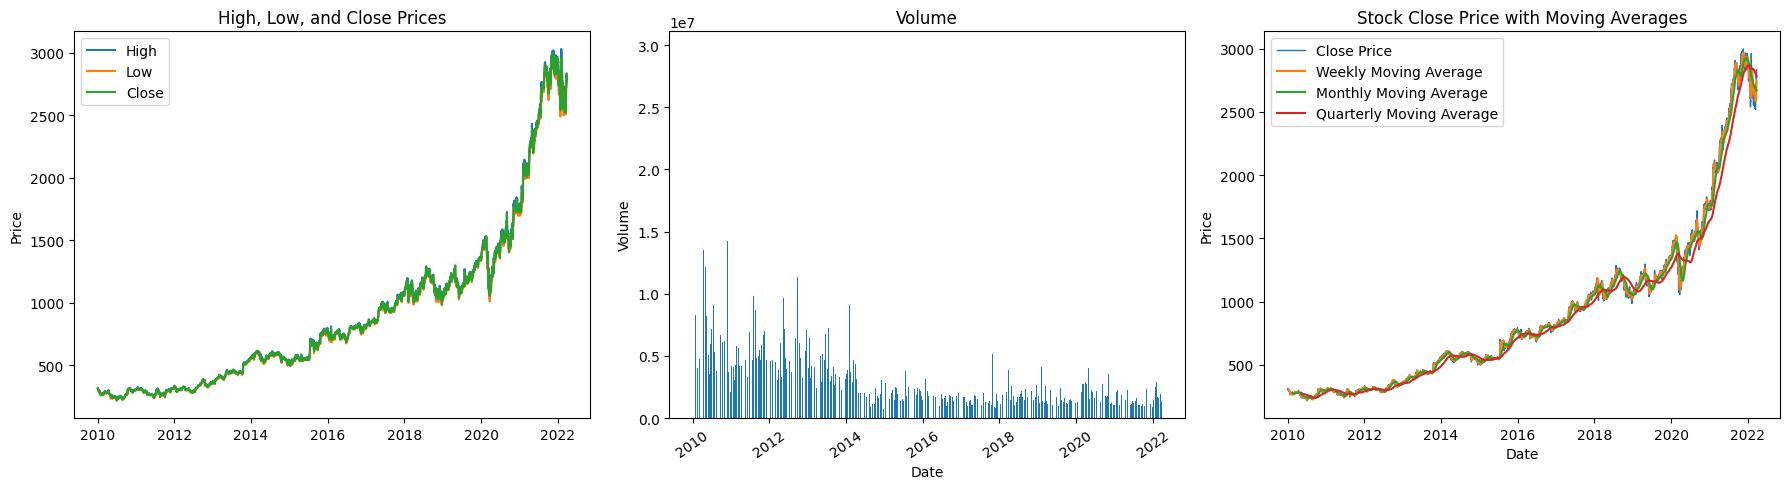




*******************************************
Training LSTM Model 1
*******************************************

Model: "sequential_92"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_155 (LSTM)             (None, 60, 128)           66560     
                                                                 
 dropout_184 (Dropout)       (None, 60, 128)           0         
                                                                 
 lstm_156 (LSTM)             (None, 64)                49408     
                                                                 
 dropout_185 (Dropout)       (None, 64)                0         
                                                                 
 dense_215 (Dense)           (None, 64)                4160      
                                                                 
 dense_216 (Dense)           (None, 32)                2080      
     

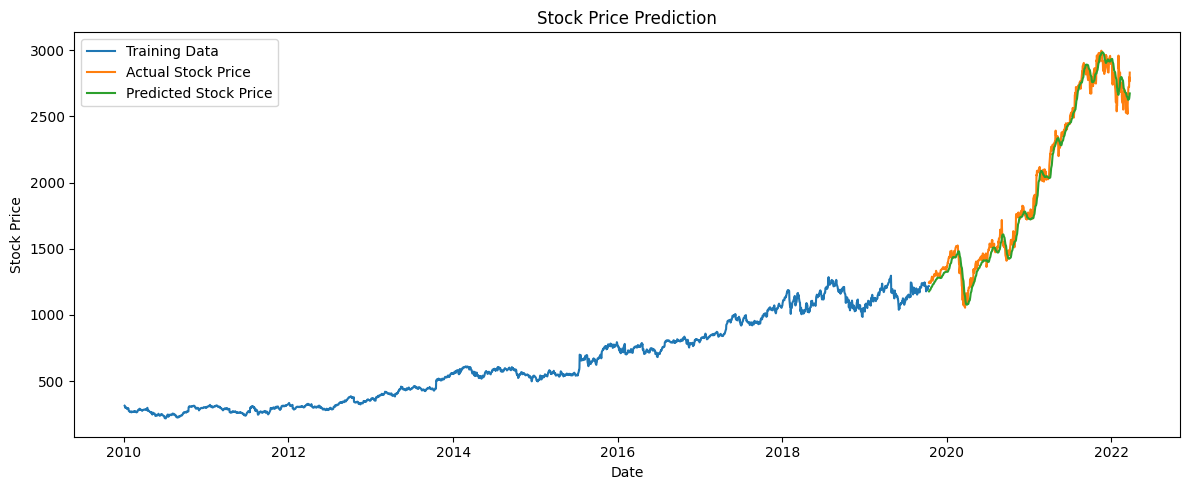




*******************************************
Training LSTM Model 2
*******************************************

Model: "sequential_93"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_157 (LSTM)             (None, 60, 64)            16896     
                                                                 
 dropout_186 (Dropout)       (None, 60, 64)            0         
                                                                 
 lstm_158 (LSTM)             (None, 32)                12416     
                                                                 
 dropout_187 (Dropout)       (None, 32)                0         
                                                                 
 dense_218 (Dense)           (None, 16)                528       
                                                                 
 dense_219 (Dense)           (None, 1)                 17        
     

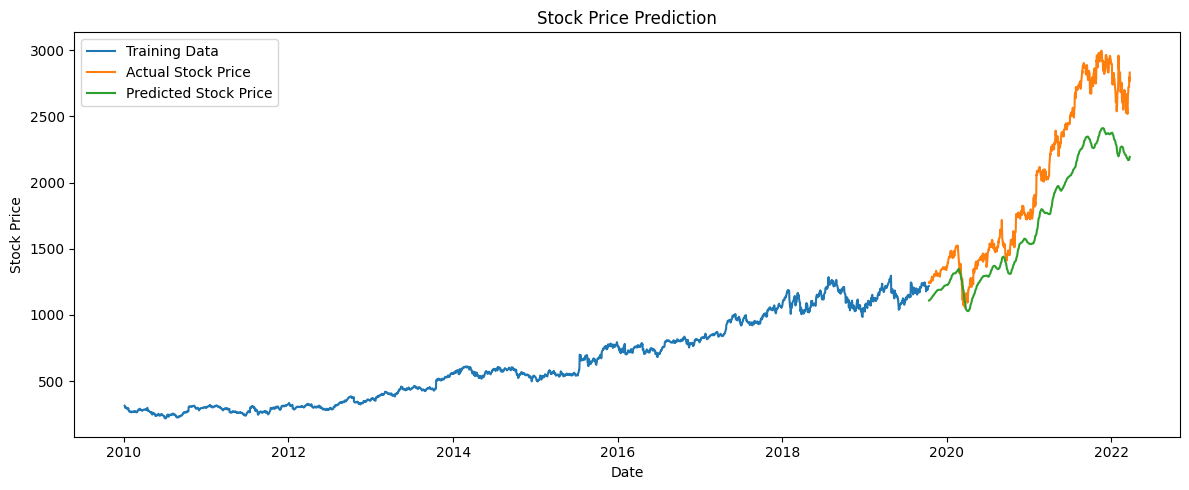




*******************************************
Training LSTM Model 3
*******************************************

Model: "sequential_94"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_159 (LSTM)             (None, 64)                16896     
                                                                 
 dropout_188 (Dropout)       (None, 64)                0         
                                                                 
 dense_220 (Dense)           (None, 32)                2080      
                                                                 
 dropout_189 (Dropout)       (None, 32)                0         
                                                                 
 dense_221 (Dense)           (None, 1)                 33        
                                                                 
Total params: 19009 (74.25 KB)
Trainable params: 19009 (74.25 KB)
Non-t

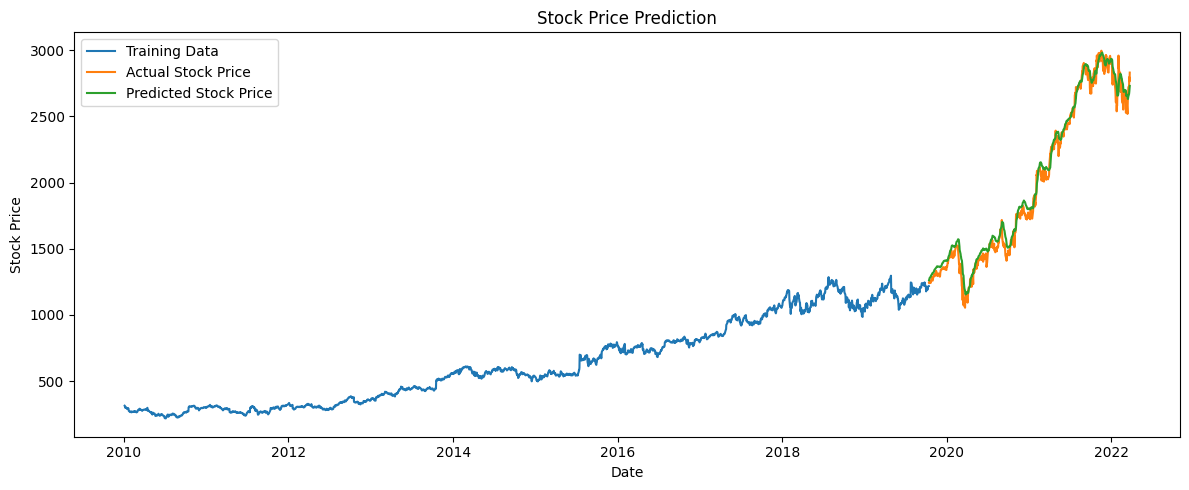

In [110]:
predict_stock_data(company_name="GOOGLE",
                   filename="GOOGL.csv",
                   seq_length=60,
                   epochs=8,
                   batch_size=32,
                   validation_split=0.2)

************************************* 
APPLE
************************************* 

===>>> INFO
Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')

===>>> HEAD
                Open      High       Low     Close  Adj Close     Volume
Date                                                                    
2010-01-04  7.622500  7.660714  7.585000  7.643214   6.535084  493729600
2010-01-05  7.664286  7.699643  7.616071  7.656429   6.546384  601904800
2010-01-06  7.656429  7.686786  7.526786  7.534643   6.442255  552160000
2010-01-07  7.562500  7.571429  7.466071  7.520714   6.430346  477131200
2010-01-08  7.510714  7.571429  7.466429  7.570714   6.473096  447610800


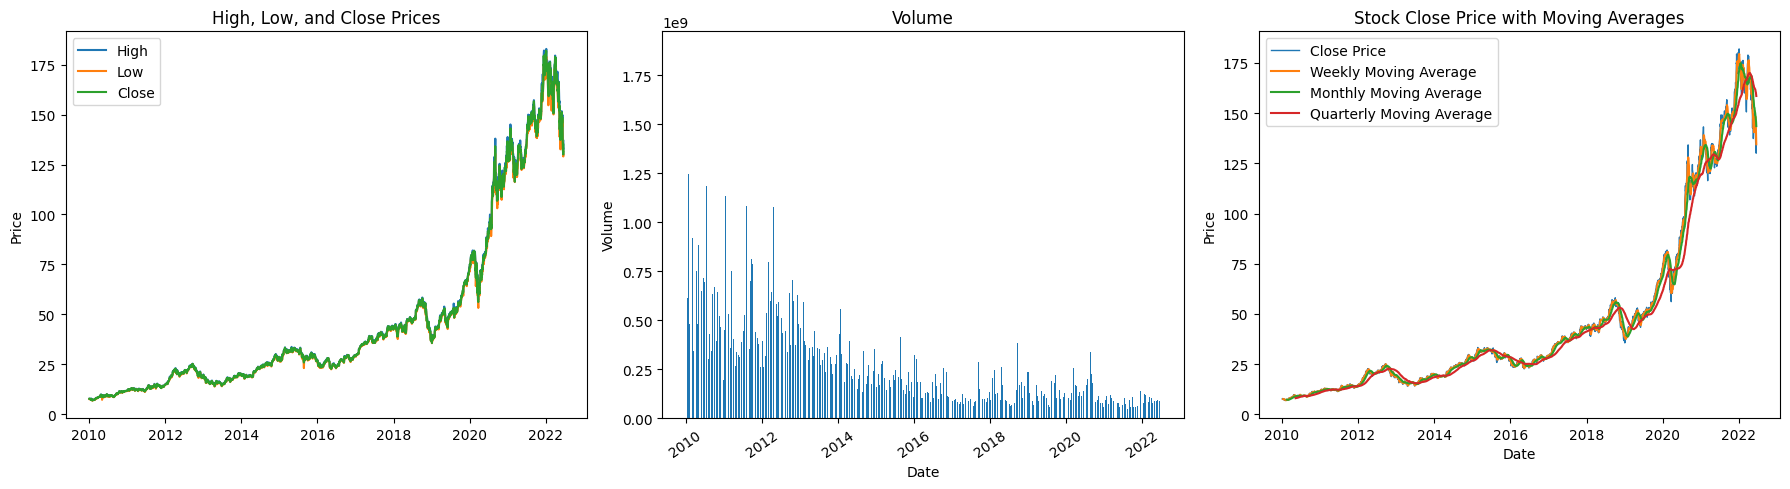




*******************************************
Training LSTM Model 1
*******************************************

Model: "sequential_95"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_160 (LSTM)             (None, 60, 128)           66560     
                                                                 
 dropout_190 (Dropout)       (None, 60, 128)           0         
                                                                 
 lstm_161 (LSTM)             (None, 64)                49408     
                                                                 
 dropout_191 (Dropout)       (None, 64)                0         
                                                                 
 dense_222 (Dense)           (None, 64)                4160      
                                                                 
 dense_223 (Dense)           (None, 32)                2080      
     

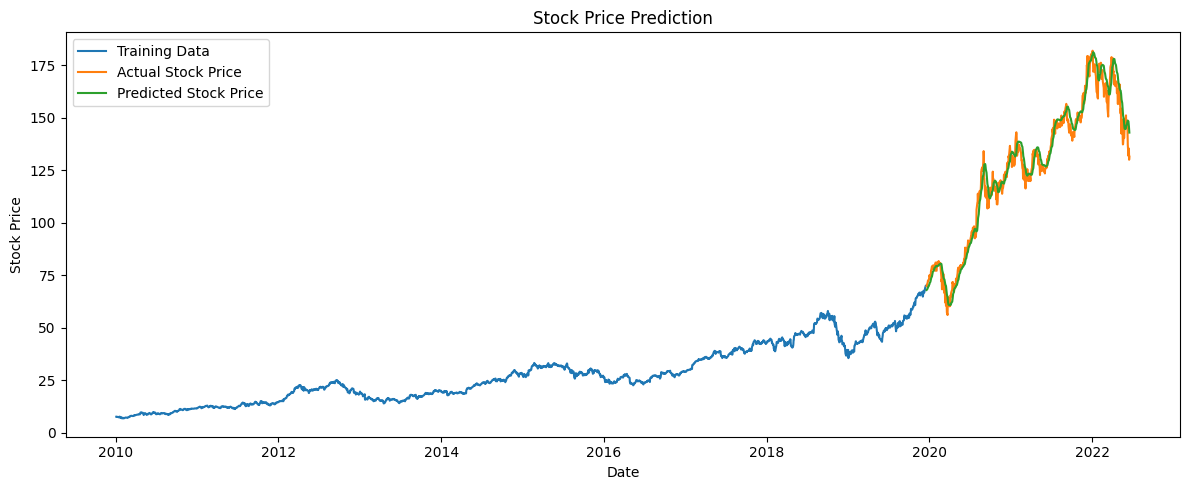




*******************************************
Training LSTM Model 2
*******************************************

Model: "sequential_96"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_162 (LSTM)             (None, 60, 64)            16896     
                                                                 
 dropout_192 (Dropout)       (None, 60, 64)            0         
                                                                 
 lstm_163 (LSTM)             (None, 32)                12416     
                                                                 
 dropout_193 (Dropout)       (None, 32)                0         
                                                                 
 dense_225 (Dense)           (None, 16)                528       
                                                                 
 dense_226 (Dense)           (None, 1)                 17        
     

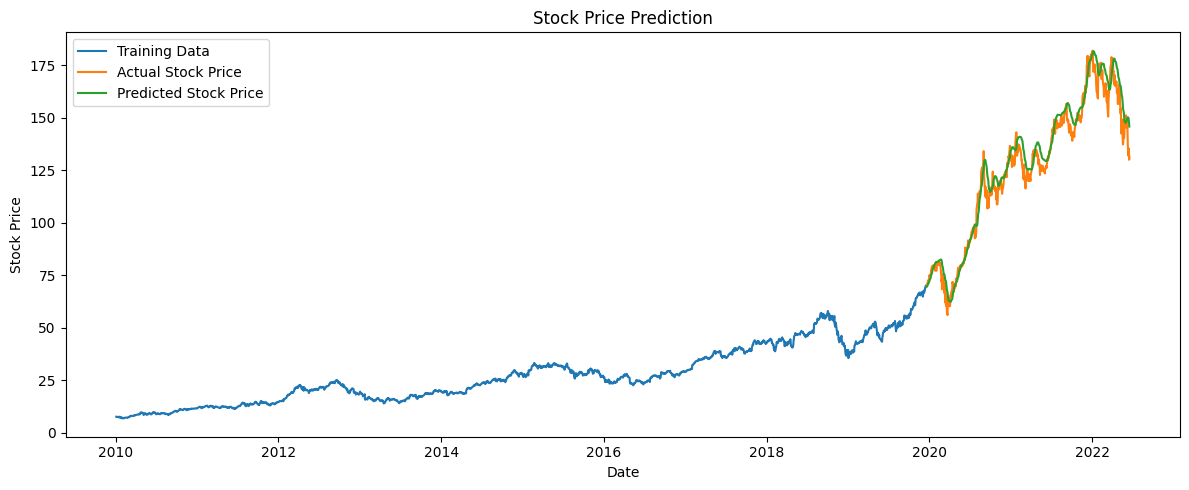




*******************************************
Training LSTM Model 3
*******************************************

Model: "sequential_97"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_164 (LSTM)             (None, 64)                16896     
                                                                 
 dropout_194 (Dropout)       (None, 64)                0         
                                                                 
 dense_227 (Dense)           (None, 32)                2080      
                                                                 
 dropout_195 (Dropout)       (None, 32)                0         
                                                                 
 dense_228 (Dense)           (None, 1)                 33        
                                                                 
Total params: 19009 (74.25 KB)
Trainable params: 19009 (74.25 KB)
Non-t

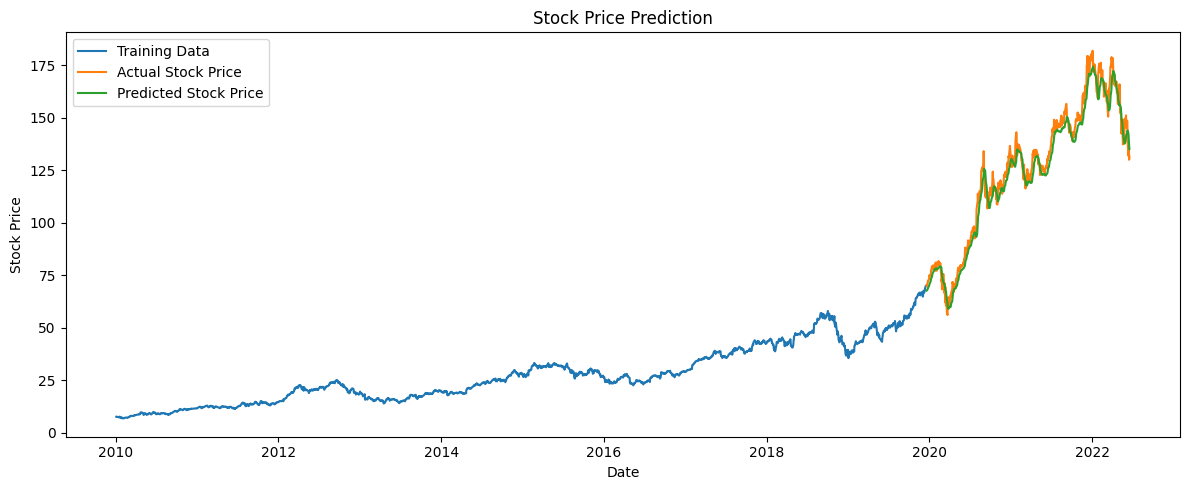

In [111]:
predict_stock_data(company_name="APPLE",
                   filename="AAPL.csv",
                   seq_length=60,
                   epochs=8,
                   batch_size=32,
                   validation_split=0.2)

************************************* 
AMAZON
************************************* 

===>>> INFO
Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')

===>>> HEAD
                  Open        High         Low       Close   Adj Close  \
Date                                                                     
2010-01-04  136.250000  136.610001  133.139999  133.899994  133.899994   
2010-01-05  133.429993  135.479996  131.809998  134.690002  134.690002   
2010-01-06  134.600006  134.729996  131.649994  132.250000  132.250000   
2010-01-07  132.009995  132.320007  128.800003  130.000000  130.000000   
2010-01-08  130.559998  133.679993  129.029999  133.520004  133.520004   

              Volume  
Date                  
2010-01-04   7599900  
2010-01-05   8851900  
2010-01-06   7178800  
2010-01-07  11030200  
2010-01-08   9830500  


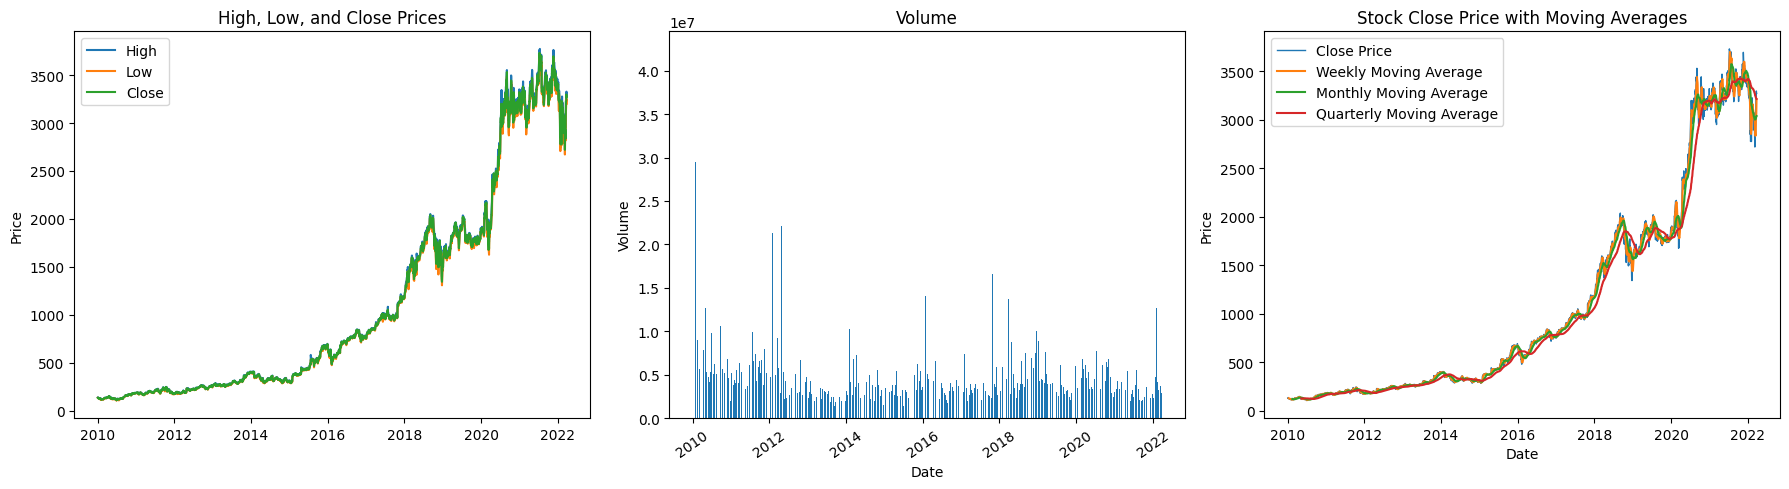




*******************************************
Training LSTM Model 1
*******************************************

Model: "sequential_98"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_165 (LSTM)             (None, 60, 128)           66560     
                                                                 
 dropout_196 (Dropout)       (None, 60, 128)           0         
                                                                 
 lstm_166 (LSTM)             (None, 64)                49408     
                                                                 
 dropout_197 (Dropout)       (None, 64)                0         
                                                                 
 dense_229 (Dense)           (None, 64)                4160      
                                                                 
 dense_230 (Dense)           (None, 32)                2080      
     

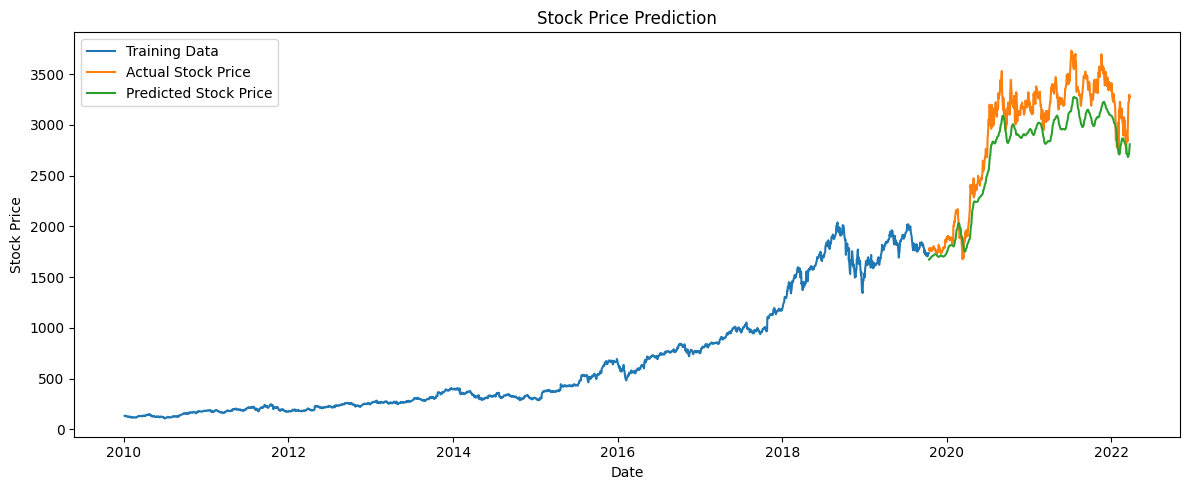




*******************************************
Training LSTM Model 2
*******************************************

Model: "sequential_99"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_167 (LSTM)             (None, 60, 64)            16896     
                                                                 
 dropout_198 (Dropout)       (None, 60, 64)            0         
                                                                 
 lstm_168 (LSTM)             (None, 32)                12416     
                                                                 
 dropout_199 (Dropout)       (None, 32)                0         
                                                                 
 dense_232 (Dense)           (None, 16)                528       
                                                                 
 dense_233 (Dense)           (None, 1)                 17        
     

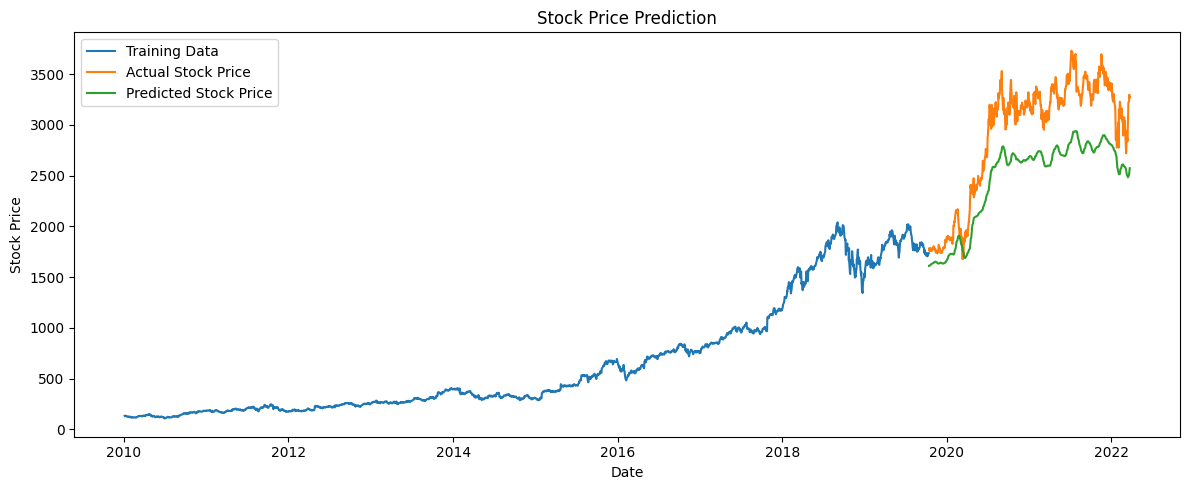




*******************************************
Training LSTM Model 3
*******************************************

Model: "sequential_100"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_169 (LSTM)             (None, 64)                16896     
                                                                 
 dropout_200 (Dropout)       (None, 64)                0         
                                                                 
 dense_234 (Dense)           (None, 32)                2080      
                                                                 
 dropout_201 (Dropout)       (None, 32)                0         
                                                                 
 dense_235 (Dense)           (None, 1)                 33        
                                                                 
Total params: 19009 (74.25 KB)
Trainable params: 19009 (74.25 KB)
Non-

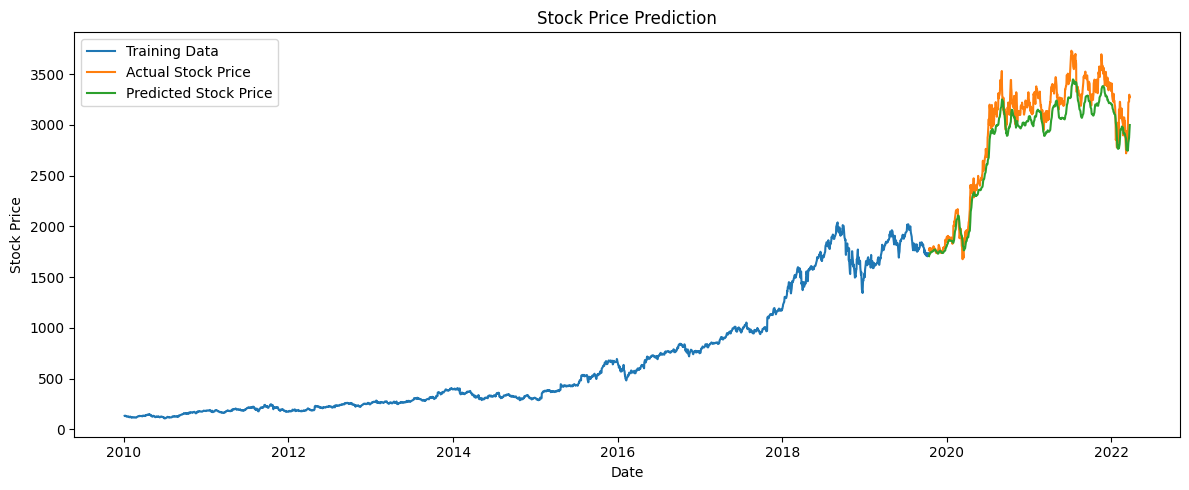

In [112]:
predict_stock_data(company_name="AMAZON",
                   filename="AMZN.csv",
                   seq_length=60,
                   epochs=8,
                   batch_size=32,
                   validation_split=0.2)

************************************* 
META
************************************* 

===>>> INFO
Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')

===>>> HEAD
                  Open        High         Low       Close   Adj Close  \
Date                                                                     
2020-01-02  206.750000  209.789993  206.270004  209.779999  209.557648   
2020-01-03  207.210007  210.399994  206.949997  208.669998  208.448837   
2020-01-06  206.699997  212.779999  206.520004  212.600006  212.374680   
2020-01-07  212.820007  214.580002  211.750000  213.059998  212.834183   
2020-01-08  213.000000  216.240005  212.610001  215.220001  214.991898   

              Volume  
Date                  
2020-01-02  12077100  
2020-01-03  11188400  
2020-01-06  17058900  
2020-01-07  14912400  
2020-01-08  13475000  


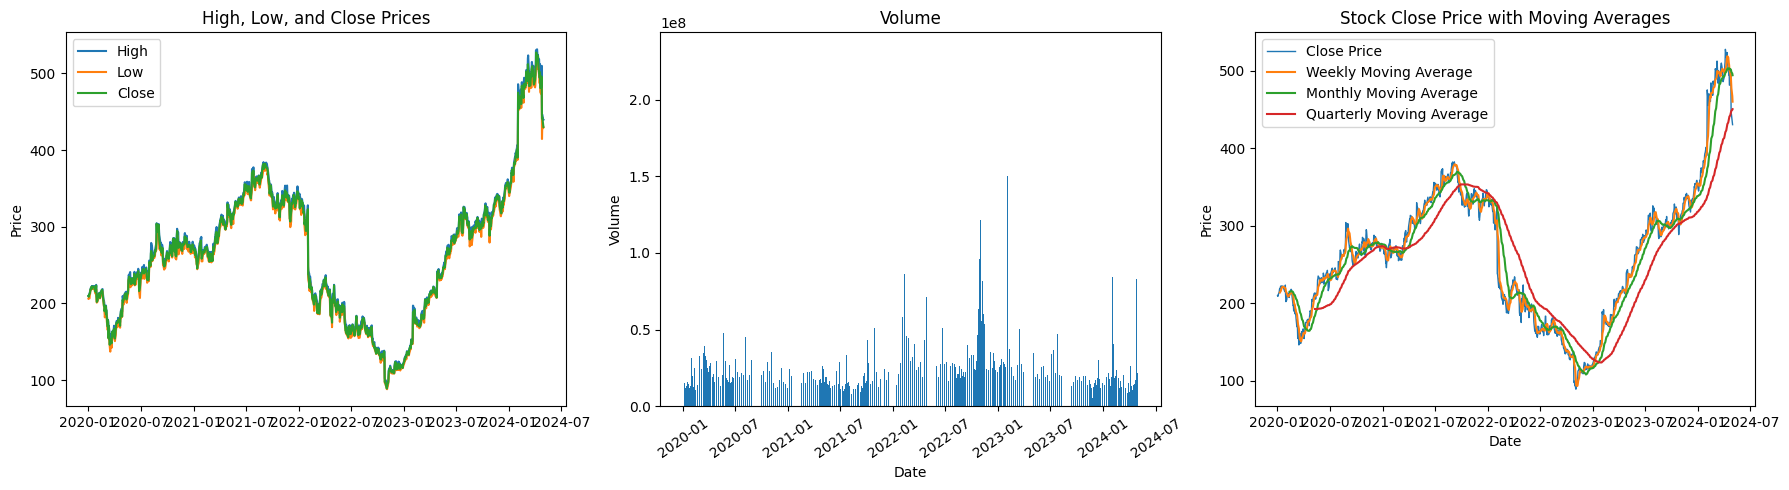




*******************************************
Training LSTM Model 1
*******************************************

Model: "sequential_101"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_170 (LSTM)             (None, 60, 128)           66560     
                                                                 
 dropout_202 (Dropout)       (None, 60, 128)           0         
                                                                 
 lstm_171 (LSTM)             (None, 64)                49408     
                                                                 
 dropout_203 (Dropout)       (None, 64)                0         
                                                                 
 dense_236 (Dense)           (None, 64)                4160      
                                                                 
 dense_237 (Dense)           (None, 32)                2080      
    

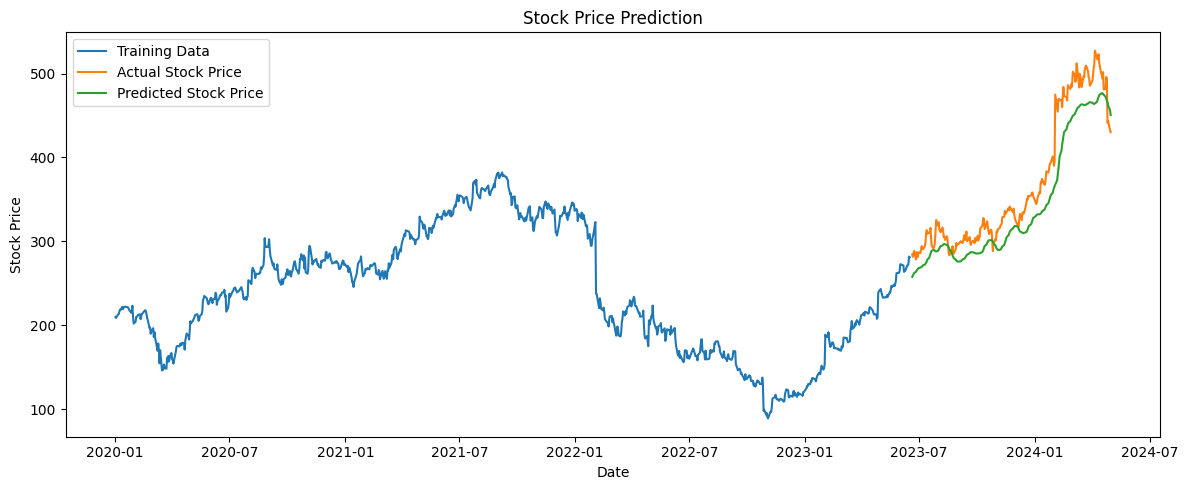




*******************************************
Training LSTM Model 2
*******************************************

Model: "sequential_102"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_172 (LSTM)             (None, 60, 64)            16896     
                                                                 
 dropout_204 (Dropout)       (None, 60, 64)            0         
                                                                 
 lstm_173 (LSTM)             (None, 32)                12416     
                                                                 
 dropout_205 (Dropout)       (None, 32)                0         
                                                                 
 dense_239 (Dense)           (None, 16)                528       
                                                                 
 dense_240 (Dense)           (None, 1)                 17        
    

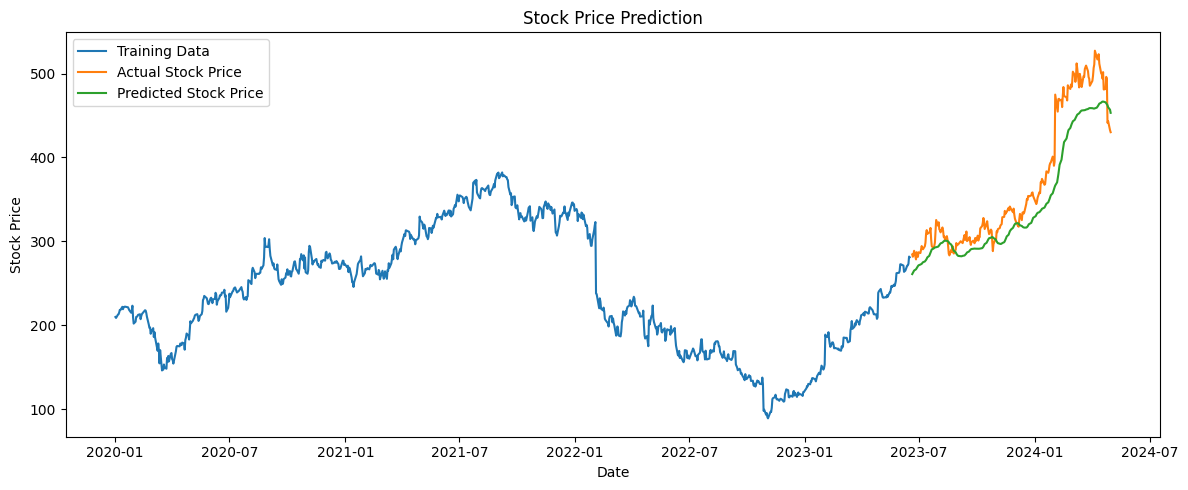




*******************************************
Training LSTM Model 3
*******************************************

Model: "sequential_103"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_174 (LSTM)             (None, 64)                16896     
                                                                 
 dropout_206 (Dropout)       (None, 64)                0         
                                                                 
 dense_241 (Dense)           (None, 32)                2080      
                                                                 
 dropout_207 (Dropout)       (None, 32)                0         
                                                                 
 dense_242 (Dense)           (None, 1)                 33        
                                                                 
Total params: 19009 (74.25 KB)
Trainable params: 19009 (74.25 KB)
Non-

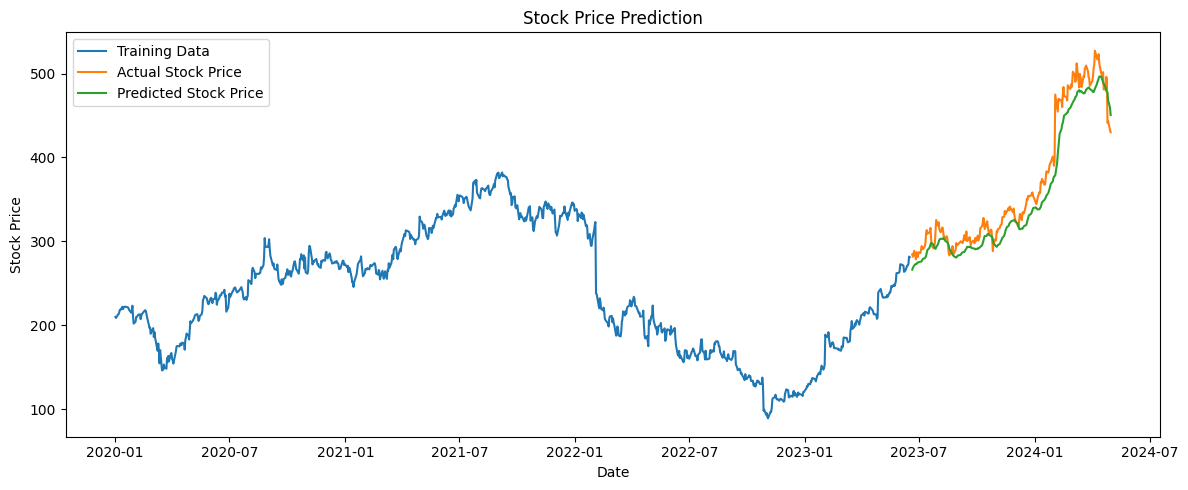

In [113]:
predict_stock_data(company_name="META",
                   filename="META.csv",
                   seq_length=60,
                   epochs=8,
                   batch_size=32,
                   validation_split=0.2)

************************************* 
MICROSOFT
************************************* 

===>>> INFO
Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')

===>>> HEAD
                 Open       High        Low      Close  Adj Close    Volume
Date                                                                       
2010-01-04  30.620001  31.100000  30.590000  30.950001  23.855661  38409100
2010-01-05  30.850000  31.100000  30.639999  30.959999  23.863363  49749600
2010-01-06  30.879999  31.080000  30.520000  30.770000  23.716917  58182400
2010-01-07  30.629999  30.700001  30.190001  30.450001  23.470270  50559700
2010-01-08  30.280001  30.879999  30.240000  30.660000  23.632128  51197400


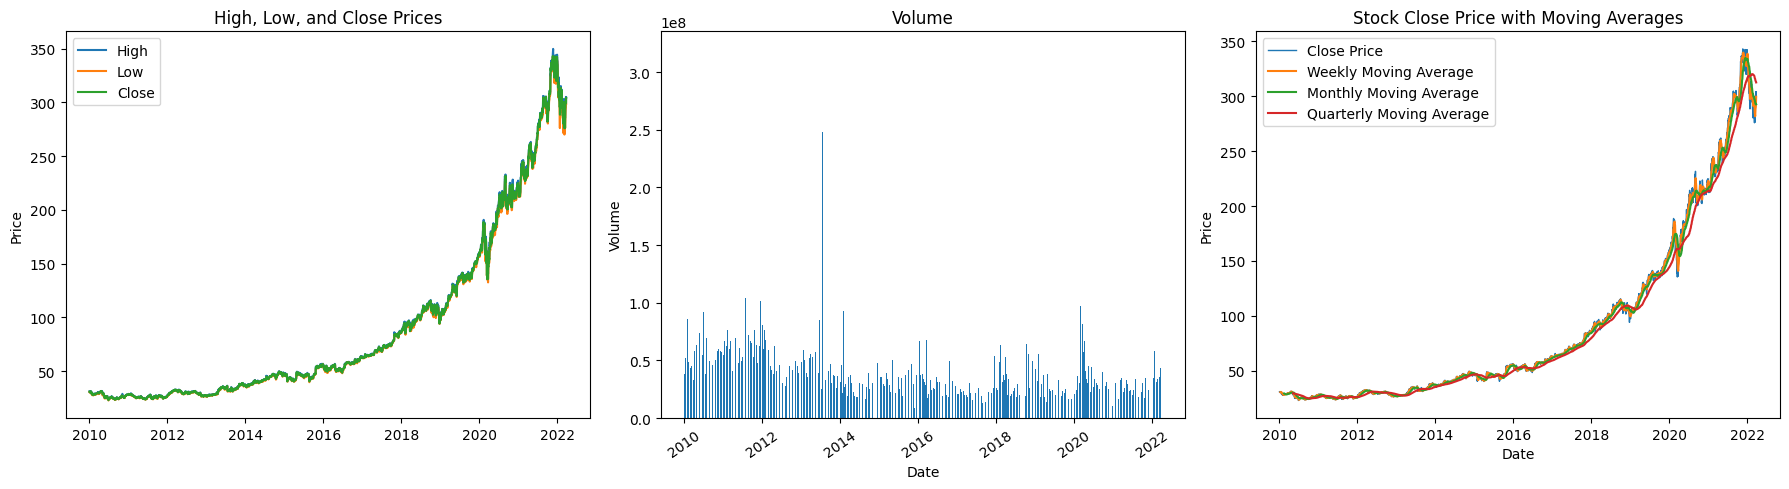




*******************************************
Training LSTM Model 1
*******************************************

Model: "sequential_104"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_175 (LSTM)             (None, 60, 128)           66560     
                                                                 
 dropout_208 (Dropout)       (None, 60, 128)           0         
                                                                 
 lstm_176 (LSTM)             (None, 64)                49408     
                                                                 
 dropout_209 (Dropout)       (None, 64)                0         
                                                                 
 dense_243 (Dense)           (None, 64)                4160      
                                                                 
 dense_244 (Dense)           (None, 32)                2080      
    

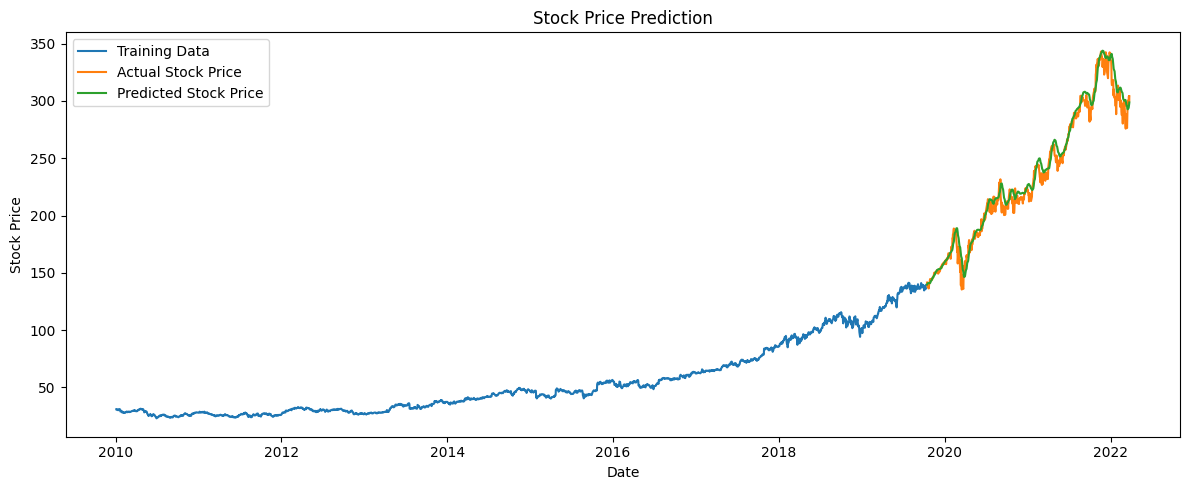




*******************************************
Training LSTM Model 2
*******************************************

Model: "sequential_105"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_177 (LSTM)             (None, 60, 64)            16896     
                                                                 
 dropout_210 (Dropout)       (None, 60, 64)            0         
                                                                 
 lstm_178 (LSTM)             (None, 32)                12416     
                                                                 
 dropout_211 (Dropout)       (None, 32)                0         
                                                                 
 dense_246 (Dense)           (None, 16)                528       
                                                                 
 dense_247 (Dense)           (None, 1)                 17        
    

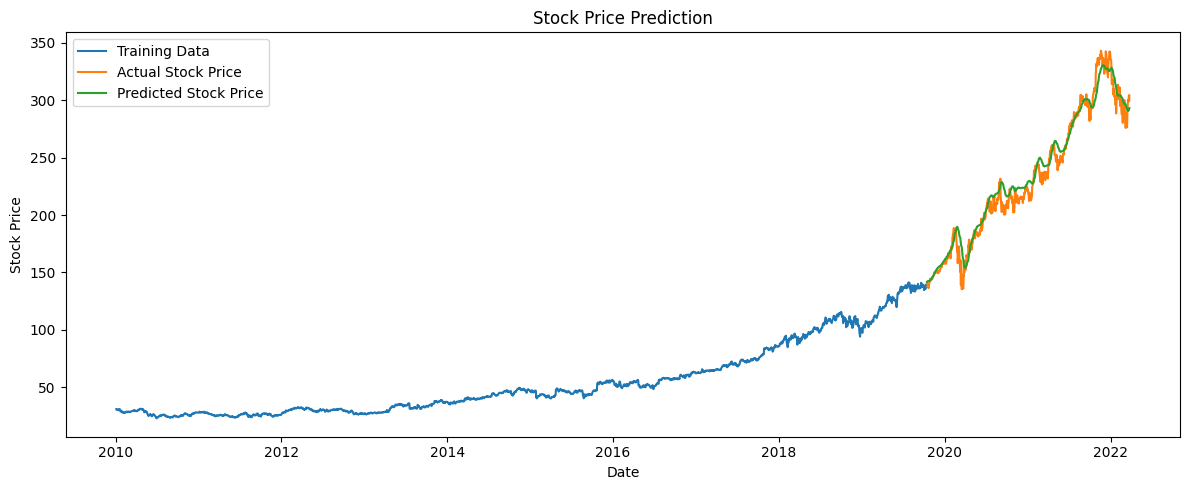




*******************************************
Training LSTM Model 3
*******************************************

Model: "sequential_106"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_179 (LSTM)             (None, 64)                16896     
                                                                 
 dropout_212 (Dropout)       (None, 64)                0         
                                                                 
 dense_248 (Dense)           (None, 32)                2080      
                                                                 
 dropout_213 (Dropout)       (None, 32)                0         
                                                                 
 dense_249 (Dense)           (None, 1)                 33        
                                                                 
Total params: 19009 (74.25 KB)
Trainable params: 19009 (74.25 KB)
Non-

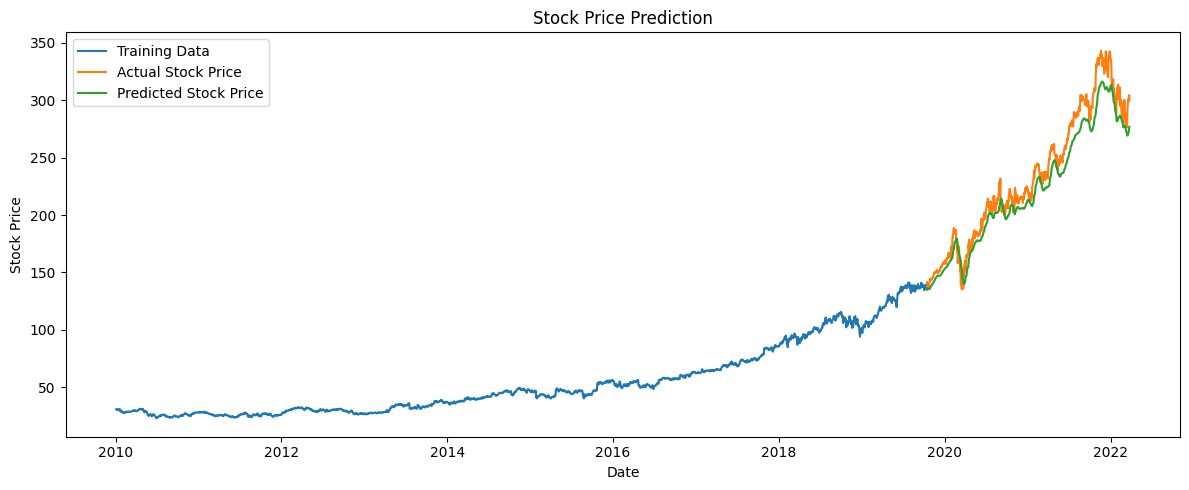

In [114]:
predict_stock_data(company_name="MICROSOFT",
                   filename="MSFT.csv",
                   seq_length=60,
                   epochs=8,
                   batch_size=32,
                   validation_split=0.2)

************************************* 
NETFLIX
************************************* 

===>>> INFO
Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')

===>>> HEAD
                  Open        High         Low       Close   Adj Close  \
Date                                                                     
2018-02-05  262.000000  267.899994  250.029999  254.259995  254.259995   
2018-02-06  247.699997  266.700012  245.000000  265.720001  265.720001   
2018-02-07  266.579987  272.450012  264.329987  264.559998  264.559998   
2018-02-08  267.079987  267.619995  250.000000  250.100006  250.100006   
2018-02-09  253.850006  255.800003  236.110001  249.470001  249.470001   

              Volume  
Date                  
2018-02-05  11896100  
2018-02-06  12595800  
2018-02-07   8981500  
2018-02-08   9306700  
2018-02-09  16906900  


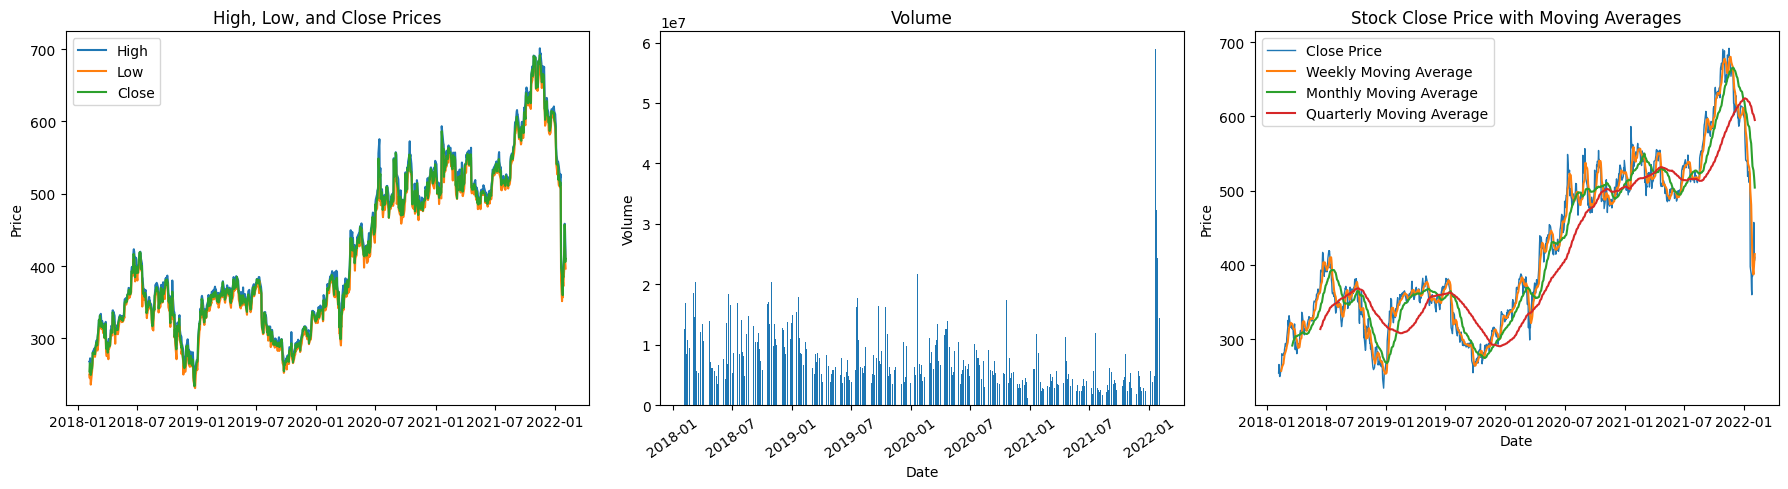




*******************************************
Training LSTM Model 1
*******************************************

Model: "sequential_107"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_180 (LSTM)             (None, 60, 128)           66560     
                                                                 
 dropout_214 (Dropout)       (None, 60, 128)           0         
                                                                 
 lstm_181 (LSTM)             (None, 64)                49408     
                                                                 
 dropout_215 (Dropout)       (None, 64)                0         
                                                                 
 dense_250 (Dense)           (None, 64)                4160      
                                                                 
 dense_251 (Dense)           (None, 32)                2080      
    

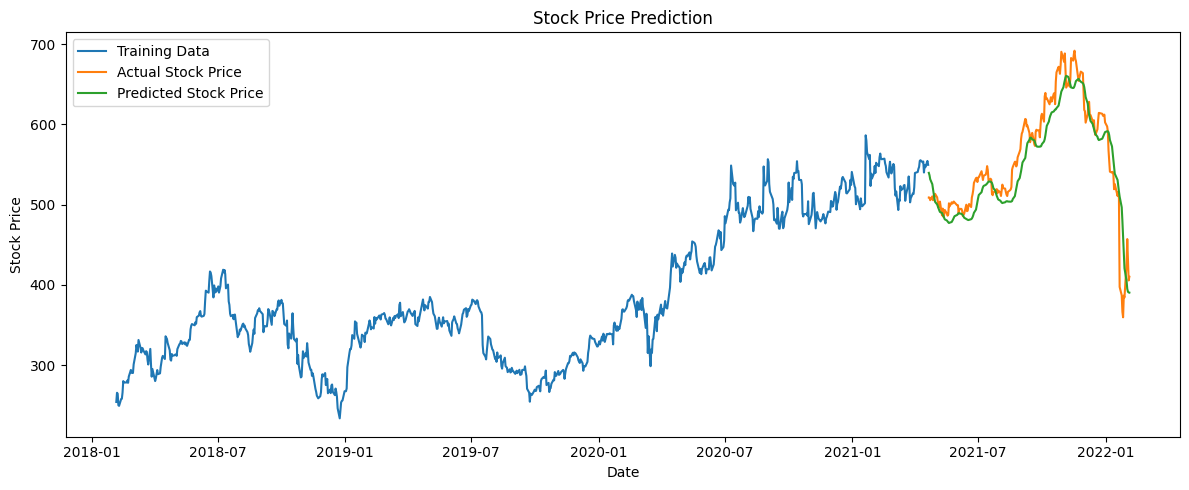




*******************************************
Training LSTM Model 2
*******************************************

Model: "sequential_108"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_182 (LSTM)             (None, 60, 64)            16896     
                                                                 
 dropout_216 (Dropout)       (None, 60, 64)            0         
                                                                 
 lstm_183 (LSTM)             (None, 32)                12416     
                                                                 
 dropout_217 (Dropout)       (None, 32)                0         
                                                                 
 dense_253 (Dense)           (None, 16)                528       
                                                                 
 dense_254 (Dense)           (None, 1)                 17        
    

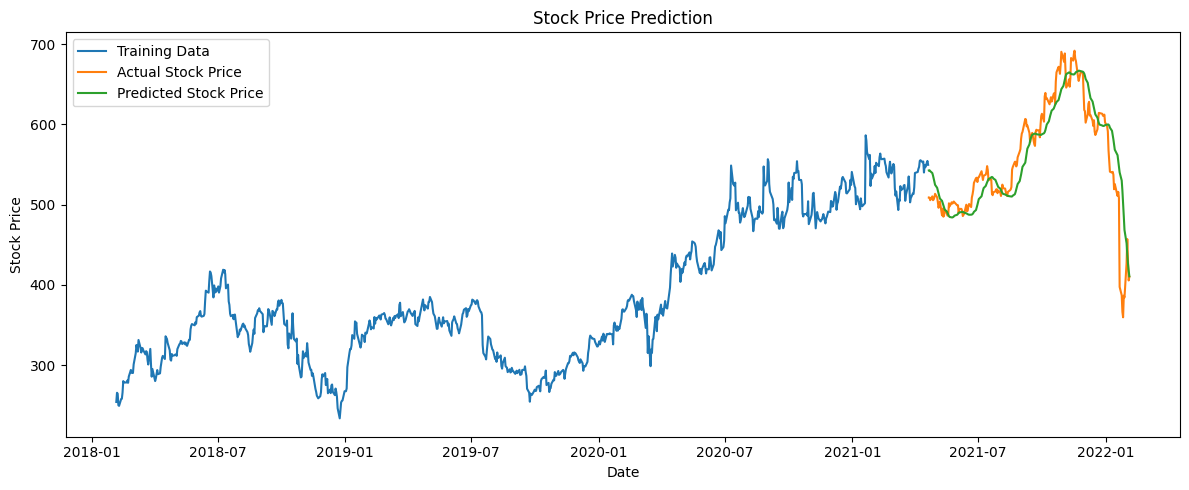




*******************************************
Training LSTM Model 3
*******************************************

Model: "sequential_109"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_184 (LSTM)             (None, 64)                16896     
                                                                 
 dropout_218 (Dropout)       (None, 64)                0         
                                                                 
 dense_255 (Dense)           (None, 32)                2080      
                                                                 
 dropout_219 (Dropout)       (None, 32)                0         
                                                                 
 dense_256 (Dense)           (None, 1)                 33        
                                                                 
Total params: 19009 (74.25 KB)
Trainable params: 19009 (74.25 KB)
Non-

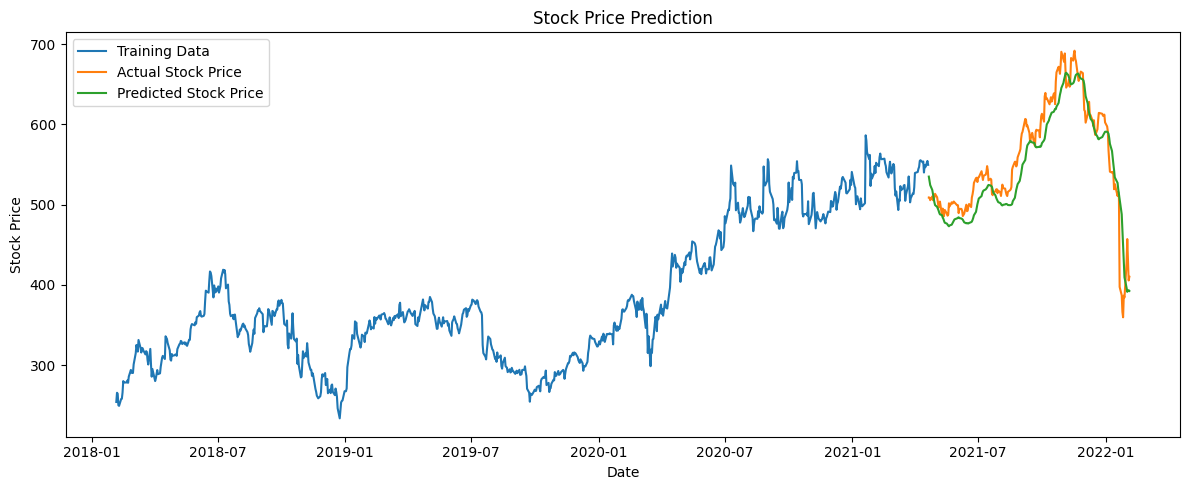

In [115]:
predict_stock_data(company_name="NETFLIX",
                   filename="NFLX.csv",
                   seq_length=60,
                   epochs=8,
                   batch_size=32,
                   validation_split=0.2)